In [ ]:
# Only for Colab, comment out if not using Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# Change this line if you're using Colab to something like '/content/drive/MyDrive/TeamX/'
# where TeamX is just the clone of repository on your Google Drive
# and you have mounted the drive at /content/drive  
# See the Tutorial Slides for more detail.

# Works on your local machine but not on Colab!
PROJECT_ROOT = '../..' 

# Fix this path and use this one on Colab
# PROJECT_ROOT = '/content/drive/MyDrive/TeamX' 

In [2]:
import sys
from os.path import join as ospj

sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

## Playing around with the data
### 1. Load the data
Using the IIT-AFF dataset, we will load the data and see what it looks like.
### 2. Visualize the data
We will visualize the data to see what it looks like.
### 3. Preprocess the data
Create a DataLoaders object for the data.

# Converting Text File to Segmentation Map

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
import cv2


data_dir = ospj(PROJECT_ROOT, 'data', 'IIT_Affordances_2017', 'IIT_Affordances_2017')

background = (200, 222, 250)
c1 = (0,0,205)   
c2 = (34,139,34) 
c3 = (192,192,128)   
c4 = (165,42,42)    
c5 = (128,64,128)   
c6 = (204,102,0)  
c7 = (184,134,11) 
c8 = (0,153,153)
c9 = (0,134,141)
c10 = (184,0,141) 
c11 = (184,134,0) 
c12 = (184,134,223)
label_colours = np.array([background, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12])

# Object
col0 = (0, 0, 0)
col1 = (0, 255, 255)
col2 = (255, 0, 255)
col3 = (0, 125, 255)
col4 = (55, 125, 0)
col5 = (255, 50, 75)
col6 = (100, 100, 50)
col7 = (25, 234, 54)
col8 = (156, 65, 15)
col9 = (215, 25, 155)
col10 = (25, 25, 155)

col_map = [col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10]


# img = Image.open(ospj(data_dir, 'rgb', '00_00000090.jpg'))
# plt.imshow(img)

In [15]:
def parse_affordance_labels(affordance_filename):
    with open(affordance_filename) as f:
        affordance_labels = f.readlines()
        dim1 = len(affordance_labels)
        dim2 = len(affordance_labels[0].split())
        
    count = 0
    # Creation of Affordance pixel grid
    # Checking image size to continue with creating Segmentation Map
    affordance_pixels = []
    for label in affordance_labels:
        row_pixels = []
        digits = label.split()
        count = 0
        for digit in digits:
            if digit.isdigit():
                if int(digit) < 0 or int(digit) > (len(label_colours) - 1):
                    digit = 0
                row_pixels.append(digit)
                count += 1
        assert count==dim2, f"Actual count: {count}"
        affordance_pixels.append(row_pixels)
            
    # dimensions = [dim1, dim2]
    affordance_pixels = np.array(affordance_pixels, dtype=np.uint8)
    # for i in range(dim1):
    #     for j in range(dim2):
    #         if affordance_pixels[i][j] < 0 or affordance_pixels[i][j] > 12:
    #             logger.info(f"Negative Value: {affordance_pixels[i][j]}")

    seg_map = label_colours[affordance_pixels]
    seg_map = torch.tensor(seg_map, dtype=torch.uint8).reshape(dim1, dim2, 3).permute(2, 0, 1)
    
    # print(seg_map.shape)

    # plt.imshow(seg_map)
    # plt.show()

    # Normalize the data to be in the range [0, 1]
    seg_map_normalized = seg_map / 255.0

    # Convert the normalized 3D NumPy array to a PIL image
    seg_map_img = transforms.ToPILImage()(seg_map_normalized)
    return seg_map_img

def parse_object_labels(object_filename):
    with open(object_filename, 'r') as file:
        lines = file.readlines()

    # Split each line into individual values and convert them to integers
    object_labels = [list(map(int, line.strip().split())) for line in lines]

    # Convert the data to a PyTorch tensor
    return torch.tensor(object_labels)

In [16]:
from transformers import SegformerFeatureExtractor

segformer_b0_feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
# segformer_b0_feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
segformer_b0_feature_extractor.reduce_labels = True
segformer_b0_feature_extractor.size = 600

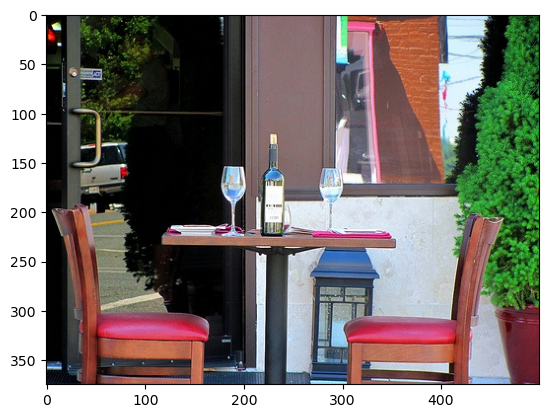

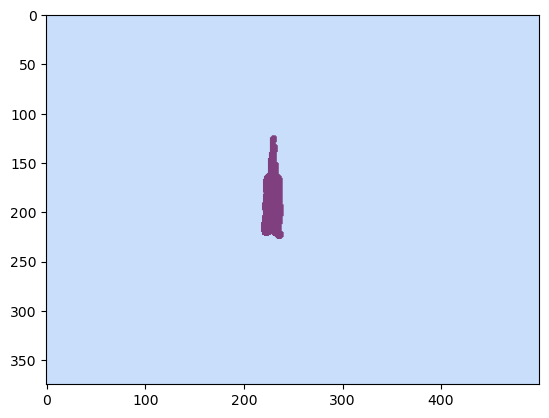

In [17]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    # transforms.Resize((600,600)),
    transforms.ToTensor(),
])

image_filename = ospj(data_dir, "rgb", "ILSVRC2014_train_00044663.jpg")
image = Image.open(image_filename).convert("RGB")
np_image = np.array(image)

# Load Affordance Label
affordance_file = "ILSVRC2014_train_00044663.jpg".replace(".jpg", ".txt")
affordance_filename = ospj(data_dir, "affordances_labels", affordance_file)
affordances_labels = parse_affordance_labels(affordance_filename)

# Load Object Label
object_file = "ILSVRC2014_train_00044663.jpg".replace(".jpg", ".txt")
object_filename = ospj(data_dir, "object_labels", object_file)
object_labels = parse_object_labels(object_filename)

# Apply transformations if provided
if transform is not None:
    tensor_image = transform(Image.fromarray(np_image))
    affordances_labels = transform(affordances_labels)

tensor_image = transforms.ToPILImage()(tensor_image).convert("RGB")
plt.imshow(tensor_image)
plt.show()

affordances_labels = transforms.ToPILImage()(affordances_labels).convert("RGB")
plt.imshow(affordances_labels)
plt.show()


# Extract features if feature_extractor is provided
if segformer_b0_feature_extractor is not None:
    encoded_inputs = segformer_b0_feature_extractor(tensor_image, affordances_labels, return_tensors="pt")
    for k,v in encoded_inputs.items():
        encoded_inputs[k].squeeze_()

In [19]:
for k, v in encoded_inputs.items():
    print(f"{k}: {v.shape}")

pixel_values: torch.Size([3, 600, 600])
labels: torch.Size([600, 600, 3])


## Experimenting with different SegFormer models

In [3]:
from transformers import SegformerFeatureExtractor, SegformerForImageClassification
from PIL import Image
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

seg_b0_feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
seg_b0_encoder_model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

# inputs = seg_b0_feature_extractor(images=img_141, segmentation_maps=seg_map, return_tensors="pt")

# print(inputs.keys())

# outputs = seg_b0_encoder_model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])


2023-07-30 19:48:22.503321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 19:48:24.404089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/nirav/miniconda3/envs/hlcv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` inst

In [ ]:
print(seg_b0_encoder_model)

In [ ]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests

seg_b0_processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
seg_b0_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

print(seg_b0_model)


In [ ]:
from PIL import Image

img = Image.open(ospj(data_dir, 'rgb', 'ILSVRC2014_train_00044663.jpg'))
plt.imshow(img)

In [ ]:
inputs = processor_1(images=img_141, bgr_image, return_tensors="pt")
outputs = model_1(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

## Yolos Object Detection

In [ ]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")



In [ ]:
inputs = image_processor(images=img, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([img.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )


In [ ]:
print(results)

# Experimenting with the DataLoader

In [3]:
import torch
import torch.nn.functional as F

def collate_fn(batch):
    images = [item["image"] for item in batch]
    affordances_labels = [item["affordances_labels"] for item in batch]
    object_labels = [item["object_labels"] for item in batch]
    encoded_inputs = [item["encoded_input"] for item in batch]

    # Pad images to the same size
    max_width = max(image.shape[-1] for image in images)
    max_height = max(image.shape[-2] for image in images)

    padded_images = [
        F.pad(image, (0, max_width - image.shape[-1], 0, max_height - image.shape[-2]))
        for image in images
    ]
    padded_images = torch.stack(padded_images)

    # # Pad affordances labels to the same size
    max_width = max(label.shape[-1] for label in affordances_labels)
    max_height = max(label.shape[-2] for label in affordances_labels)
    padded_affordances_labels = [
        F.pad(label, (0, max_width - label.shape[-1], 0, max_height - label.shape[-2]))
        for label in affordances_labels
    ]
    padded_affordances_labels = torch.stack(padded_affordances_labels)

    # Pad objects labels to the same size
    max_length = max(label.shape[0] for label in object_labels)
    padded_object_labels = [
        F.pad(label, (0, 0, 0, max_length - label.shape[0]))
        for label in object_labels
    ]

    # Stack the encoded inputs
    # for i in range(len(encoded_inputs)):
    #     for k, v in encoded_inputs[i].items():
    #         encoded_inputs[i][k] = torch.stack(v)

    return {
        "image": padded_images,
        "affordances_labels": padded_affordances_labels,
        "object_labels": torch.stack(padded_object_labels),
        "encoded_input": encoded_inputs
    }

In [26]:
from data_loaders.AffordanceDataset import AffordanceDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
from transformers import SegformerFeatureExtractor

data_dir = ospj(PROJECT_ROOT, 'data', 'IIT_Affordances_2017', 'IIT_Affordances_2017')

segformer_b0_feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
# segformer_b0_feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
segformer_b0_feature_extractor.reduce_labels = True
segformer_b0_feature_extractor.size = 600


transform = Compose([Resize((600,600)),
                     ToTensor()])

# transform = None

# example_dataset = AffordanceDataset(root_dir=data_dir,
#                                 split_file="example.txt",
#                                 feature_extractor=segformer_b0_feature_extractor,
#                                 transform=transform)

# train_dataset = AffordanceDataset(root_dir=data_dir,
#                                 split_file="train_and_val.txt",
#                                 feature_extractor=segformer_b0_feature_extractor,
#                                 transform=transform)
                    

validation_dataset = AffordanceDataset(root_dir=data_dir, 
                                  split_file="val.txt",
                                  feature_extractor=segformer_b0_feature_extractor, 
                                  transform=transform)

test_dataset = AffordanceDataset(root_dir=data_dir,
                                split_file="test.txt",
                                feature_extractor=segformer_b0_feature_extractor,
                                transform=transform)

batch_size = 8

# example_loader = DataLoader(example_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [27]:
torch.cuda.empty_cache()

In [28]:
from trainers.segformer_trainer1 import SegformerFinetuner


segformer_finetuner = SegformerFinetuner(
    validation_dataset.id2label, 
    train_dataloader=validation_loader, 
    val_dataloader=None, 
    test_dataloader=test_loader, 
    metrics_interval=10,
)

id2label: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label2id: dict_keys(['background', 'contain', 'cut', 'display', 'engine', 'grasp', 'hit', 'pound', 'support', 'w-grasp'])
id2label: <class 'dict'>
label2id: <class 'dict'>
num_classes: 10


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([10, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/mnt/c/Users/Nirav/Documents/Saarland University/2023SoSe/HLCV/project/hlcv-project/src/notebooks/../../src/trainers/segformer_trainer1.py:39: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.train_mean_iou = load_metric("mean_iou")


In [ ]:
torch.cuda.empty_cache()

In [6]:
from utils.parse_batch import parse_encoded_input, parse_object_labels

for batch in example_loader:
    torch.cuda.empty_cache()
    images, masks = parse_encoded_input(batch['encoded_input'])
    

8


/mnt/c/Users/Nirav/Documents/Saarland University/2023SoSe/HLCV/project/hlcv-project/src/notebooks/../../src/utils/parse_batch.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(encoded_input['pixel_values']), torch.tensor(encoded_input['labels'])


torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
8
torch.Size([8, 3, 600, 600])
